# Warning :
# Do "File -> Save a copy in Drive" before you start modifying the notebook, otherwise your modifications will not be saved.


Avant de commencer le TP, vérifiez que vous êtes sur un environnement GPU et python 3 :

Exécution -> Modifier le type d'exécution -> Type d'exécution = python2, Accélerateur matériel = GPU

In [ ]:
import argparse
import os
import time

import PIL
from PIL import Image

import numpy as np
import torchvision
import pickle

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

from sklearn.svm import LinearSVC

# Partie 1 : Architecture VGG16

In [ ]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/imagenet_classes.pkl
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl

# Bonus : Classifiez des exemples avec vgg16 et commentez le résultat dans votre rapport.
!wget --content-disposition https://unsplash.com/photos/gKXKBY-C-Dk/download?force=true -O cat.jpg
!wget --content-disposition https://unsplash.com/photos/qO-PIF84Vxg/download?force=true -O dog.jpg

--2023-12-15 13:19:58--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/imagenet_classes.pkl
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl [following]
--2023-12-15 13:19:58--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/imagenet_classes.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35454 (35K) [text/plain]
Saving to: ‘imagenet_classes.pkl’

imagenet_classes.pk 100%[===================>]  34.62K  --.-KB/s    in 0.003s  

2023-12-15 13:19:58 (12.8 MB/s) - ‘imagenet_classes.pkl’ saved [3

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 59.3MB/s]


(1, 1000)
 predicted class :  [478]
Predicted class label: carton
 Class score :  [11.122571]


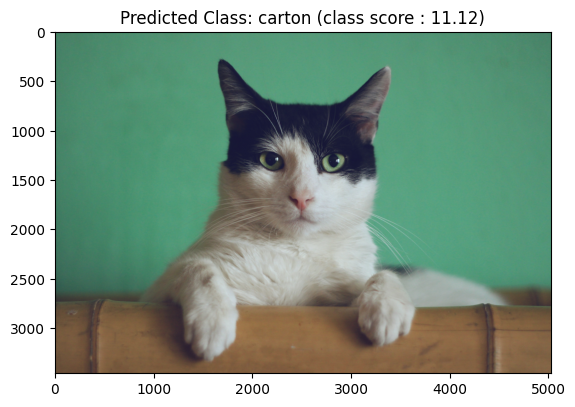

In [ ]:
cat = Image.open('cat.jpg')
dog = Image.open('dog.jpg')
#plt.imshow(cat)
#plt.imshow(dog)
# Ajoutez vos images
# VOTRE CODE ICI pour le bonus:

vgg16 = torchvision.models.vgg16(pretrained=True)

imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb'))  # load classes

img = Image.open("cat.jpg")
#img = Image.open("dog.jpg")
img = img.resize((224, 224), Image.BILINEAR)
img = np.array(img, dtype=np.float32) / 255
img = img.transpose((2, 0, 1))

# normalize with mean std
mu = np.array([0.485,0.456,0.406]).reshape(-1,1,1)
sig = np.array([0.229,0.224,0.225]).reshape(-1,1,1)
img = (img - mu) / sig

img = np.expand_dims(img, 0) # transform into a batch containing one image
x = torch.Tensor(img)
y = vgg16(x)  #forward pass
y = y.detach().numpy() # transform to numpy array

print(y.shape)
print(" predicted class : ", y.argmax(-1))
print("Predicted class label:", imagenet_classes[y.argmax(-1).item()])
print(" Class score : ", y.max(-1))
plt.imshow(cat)
#plt.imshow(dog)
plt.title(f'Predicted Class: {imagenet_classes[y.argmax(-1).item()]} (class score : {y.max(-1)[0]:.2f})')
plt.show()

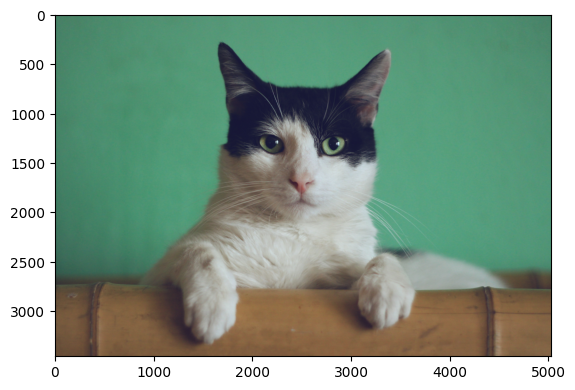

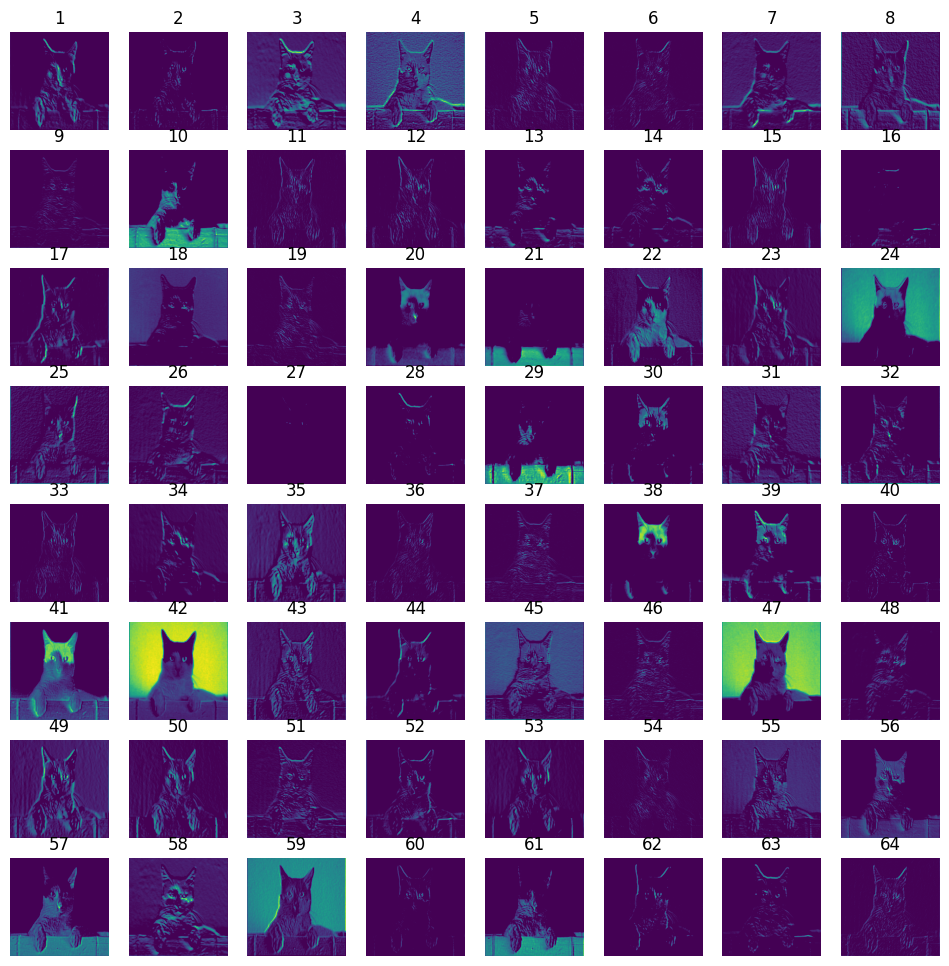

In [ ]:
cat = Image.open('cat.jpg')
#dog = Image.open('dog.jpg')
plt.imshow(cat)
#plt.imshow(dog)
# Ajoutez vos images
# VOTRE CODE ICI pour le bonus:

vgg16 = torchvision.models.vgg16(pretrained=True)

imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb')) # chargement des classes
img = Image.open("cat.jpg")
#img = Image.open("dog.jpg")
img = img.resize((224, 224), Image.BILINEAR)
img = np.array(img, dtype=np.float32) / 255
img = img.transpose((2, 0, 1))
# normalize with mean std
mu = np.array([0.485,0.456,0.406]).reshape(-1,1,1)
sig = np.array([0.229,0.224,0.225]).reshape(-1,1,1)
img = (img - mu) / sig

img = np.expand_dims(img, 0)
x = torch.Tensor(img)

model_conv1 = vgg16.features[:4]  # Extract the first convolutional layer
activation_maps = model_conv1(x)
activation_maps = activation_maps.detach().numpy()

rows,cols = 8,8
num_maps = activation_maps.shape[1]  # Number of feature maps
fig, axes = plt.subplots(8, 8, figsize=(12, 12))

for i in range(rows):
    for j in range(cols):
        map_index = i * cols + j
        if map_index < num_maps:
            axes[i, j].imshow(activation_maps[0, map_index], cmap='viridis')
            axes[i, j].axis('off')
            axes[i, j].set_title(f'{map_index + 1}')
plt.show()

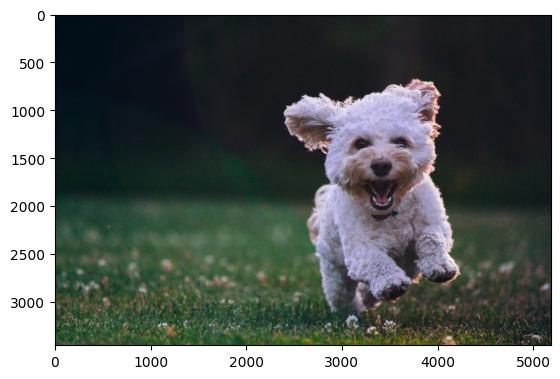

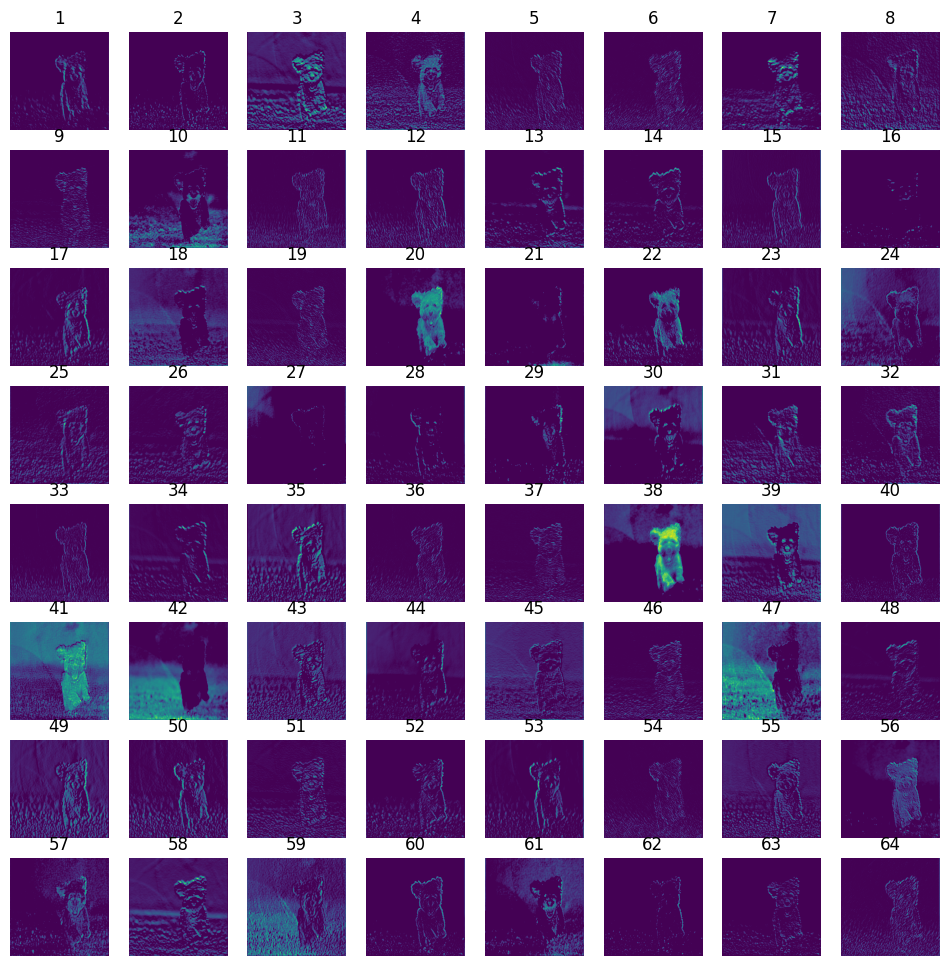

In [ ]:
#cat = Image.open('cat.jpg')
dog = Image.open('dog.jpg')
#plt.imshow(cat)
plt.imshow(dog)
# Ajoutez vos images
# VOTRE CODE ICI pour le bonus:

vgg16 = torchvision.models.vgg16(pretrained=True)

imagenet_classes = pickle.load(open('imagenet_classes.pkl', 'rb')) # chargement des classes
#img = Image.open("cat.jpg")
img = Image.open("dog.jpg")
img = img.resize((224, 224), Image.BILINEAR)
img = np.array(img, dtype=np.float32) / 255
img = img.transpose((2, 0, 1))
# normalize with mean std
mu = np.array([0.485,0.456,0.406]).reshape(-1,1,1)
sig = np.array([0.229,0.224,0.225]).reshape(-1,1,1)
img = (img - mu) / sig

img = np.expand_dims(img, 0)
x = torch.Tensor(img)

model_conv1 = vgg16.features[:4]  # Extract the first convolutional layer
activation_maps = model_conv1(x)
activation_maps = activation_maps.detach().numpy()

rows,cols = 8,8
num_maps = activation_maps.shape[1]  # Number of feature maps
fig, axes = plt.subplots(8, 8, figsize=(12, 12))

for i in range(rows):
    for j in range(cols):
        map_index = i * cols + j
        if map_index < num_maps:
            axes[i, j].imshow(activation_maps[0, map_index], cmap='viridis')
            axes[i, j].axis('off')
            axes[i, j].set_title(f'{map_index + 1}')
plt.show()

# Partie 2: Transfer Learning avec VGG16 sur 15 Scene

In [ ]:
#!wget https://github.com/cdancette/deep-learning-polytech-tp6-7/raw/master/tp8/15ScenesData.zip
!wget https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip

!unzip -o 15ScenesData.zip -d /content/

--2023-12-15 13:20:36--  https://github.com/rdfia/rdfia.github.io/raw/master/data/3-a/15ScenesData.zip
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip [following]
--2023-12-15 13:20:36--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/data/3-a/15ScenesData.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86520868 (83M) [application/zip]
Saving to: ‘15ScenesData.zip’

15ScenesData.zip    100%[===================>]  82.51M   336MB/s    in 0.2s    

2023-12-15 13:20:38 (336 MB/s) - ‘15ScenesData.zip’ saved [86520868/86520

In [ ]:
ls 15SceneData/test/bedroom/

image_0003.jpg  image_0035.jpg  image_0068.jpg  image_0103.jpg  image_0141.jpg  image_0182.jpg
image_0004.jpg  image_0037.jpg  image_0069.jpg  image_0104.jpg  image_0142.jpg  image_0189.jpg
image_0006.jpg  image_0039.jpg  image_0071.jpg  image_0112.jpg  image_0144.jpg  image_0190.jpg
image_0007.jpg  image_0040.jpg  image_0073.jpg  image_0113.jpg  image_0148.jpg  image_0191.jpg
image_0008.jpg  image_0042.jpg  image_0074.jpg  image_0114.jpg  image_0150.jpg  image_0192.jpg
image_0011.jpg  image_0043.jpg  image_0077.jpg  image_0115.jpg  image_0152.jpg  image_0195.jpg
image_0013.jpg  image_0047.jpg  image_0080.jpg  image_0117.jpg  image_0153.jpg  image_0196.jpg
image_0014.jpg  image_0049.jpg  image_0081.jpg  image_0118.jpg  image_0156.jpg  image_0200.jpg
image_0016.jpg  image_0050.jpg  image_0082.jpg  image_0119.jpg  image_0157.jpg  image_0202.jpg
image_0017.jpg  image_0052.jpg  image_0084.jpg  image_0120.jpg  image_0158.jpg  image_0203.jpg
image_0018.jpg  image_0053.jpg  image_0086.jpg  im

In [ ]:
class VGG16relu7(nn.Module):
  def __init__(self):
    super(VGG16relu7, self).__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential( *list(vgg16.features.children()))
    # Keep a piece of the classifier: -2 to stop at relu7
    self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-2])

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [ ]:

PRINT_INTERVAL = 50
CUDA = True

def get_dataset(batch_size, path):

    # Cette fonction permet de recopier 3 fois une image qui
    # ne serait que sur 1 channel (donc image niveau de gris)
    # pour la "transformer" en image RGB. Utilisez la avec
    # transform.Lambda
    def duplicateChannel(img):
        img = img.convert('L')
        np_img = np.array(img, dtype=np.uint8)
        np_img = np.dstack([np_img, np_img, np_img])
        img = Image.fromarray(np_img, 'RGB')
        return img

    #####################
    ## Votre code ici  ##
    #####################
    # Ajouter le pré-traitement
    train_dataset = datasets.ImageFolder(path+'/train',
        transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224,224)),
            transforms.Lambda(lambda x: duplicateChannel(x) if x.shape[2] == 1 else x),
            transforms.Normalize(mu,sig)
        ]))

    val_dataset = datasets.ImageFolder(path+'/test',
        transform=transforms.Compose([ # Pré-traitement à faire
            transforms.ToTensor(),
            transforms.Resize((224,224)),
            transforms.Lambda(lambda x: duplicateChannel(x) if x.shape[2] == 1 else x),
            transforms.Normalize(mu,sig)
        ]))
    ####################
    ##      FIN        #
    ####################

    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)
    val_loader = torch.utils.data.DataLoader(val_dataset,
                        batch_size=batch_size, shuffle=False, pin_memory=CUDA, num_workers=2)

    return train_loader, val_loader

In [ ]:
def extract_features(data, model):
    #####################
    ## Votre code ici  ##
    #####################
    # init features matrices
    X = None
    y = None
    ####################
    ##      FIN        #
    ####################

    for i, (input, target) in enumerate(data):
        if i % PRINT_INTERVAL == 0:
            print('Batch {0:03d}/{1:03d}'.format(i, len(data)))
        if CUDA:
            input = input.cuda()
        #####################
        ## Votre code ici  ##
        #####################
        # Feature extraction à faire

        features = model(input).cpu().detach()

        #features = model(input).cpu().detach().numpy()
        if X is None:
            X = features
            y = target.numpy()
        else:
            X = np.concatenate((X, features), axis=0)
            y = np.concatenate((y, target.numpy()), axis=0)
        ####################
        ##      FIN        #
        ####################

    return X, y


def main(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16relu7')
    #####################
    ## Votre code ici  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    #model = vgg16
    model = VGG16relu7()

    ####################
    ##      FIN        #
    ####################

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)
    # Normalisation l2
    X_train = torch.from_numpy(X_train)
    X_test = torch.from_numpy(X_test)
    X_train = nn.functional.normalize(X_train, p=2, dim=1)
    X_test = nn.functional.normalize(X_test, p=2, dim=1)

    #####################
    ## Votre code ici  ##
    #####################
    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage des SVM')
    svm_classifier = LinearSVC(C=1, max_iter=5000)
    svm_classifier.fit(X_train, y_train)

    y_pred_train = svm_classifier.predict(X_train)
    y_pred_test = svm_classifier.predict(X_test)

    accuracy = 0
    accuracy_train = svm_classifier.score(X_train, y_train)
    accuracy_test = svm_classifier.score(X_test, y_test)

    ####################
    ##      FIN        #
    ####################
    print('Accuracy train = %f' % accuracy_train)
    print('Accuracy test = %f' % accuracy_test)


In [ ]:
main("15SceneData", 8)

Instanciation de VGG16


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16relu7
Récupération des données
Feature extraction


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
Accuracy train = 0.992000
Accuracy test = 0.887772


# Going further


## Effect of the layer at which the features are extracted

In [ ]:
list(vgg16.classifier.children())[:-2]

[Linear(in_features=25088, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True)]

In [ ]:
list(vgg16.classifier.children())[:-5]

[Linear(in_features=25088, out_features=4096, bias=True), ReLU(inplace=True)]

In [ ]:
class VGG16relu6(nn.Module):
  def __init__(self):
    super(VGG16relu6, self).__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential( *list(vgg16.features.children()))

    self.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-5])

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [ ]:
def main6(path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16relu6')
    #####################
    ## Votre code ici  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    #model = vgg16
    model = VGG16relu6()

    ####################
    ##      FIN        #
    ####################

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)
    # Normalisation l2
    X_train = torch.from_numpy(X_train)
    X_test = torch.from_numpy(X_test)
    X_train = nn.functional.normalize(X_train, p=2, dim=1)
    X_test = nn.functional.normalize(X_test, p=2, dim=1)

    #####################
    ## Votre code ici  ##
    #####################
    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage des SVM')
    svm_classifier = LinearSVC(C=1, max_iter=5000)
    svm_classifier.fit(X_train, y_train)

    y_pred_train = svm_classifier.predict(X_train)
    y_pred_test = svm_classifier.predict(X_test)

    accuracy = 0
    accuracy_train = svm_classifier.score(X_train, y_train)
    accuracy_test = svm_classifier.score(X_test, y_test)

    ####################
    ##      FIN        #
    ####################
    print('Accuracy train = %f' % accuracy_train)
    print('Accuracy test = %f' % accuracy_test)

In [ ]:
main6("15SceneData", 8)

Instanciation de VGG16


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16relu6
Récupération des données
Feature extraction


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
Accuracy train = 0.997333
Accuracy test = 0.910218


## Different pre-trained network

In [ ]:
alexnet = models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
list(alexnet.children())

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
   (1): ReLU(inplace=True)
   (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
   (4): ReLU(inplace=True)
   (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
   (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (7): ReLU(inplace=True)
   (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (9): ReLU(inplace=True)
   (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
   (11): ReLU(inplace=True)
   (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
 ),
 AdaptiveAvgPool2d(output_size=(6, 6)),
 Sequential(
   (0): Dropout(p=0.5, inplace=False)
   (1): Linear(in_features=9216, out_features=4096, bias=True)
   (2): ReLU(inplace=True)
   (3): Dropout(p=0.5, inplace=False)

In [ ]:
list(alexnet.classifier.children())

[Dropout(p=0.5, inplace=False),
 Linear(in_features=9216, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Linear(in_features=4096, out_features=1000, bias=True)]

In [ ]:
list(alexnet.classifier.children())[:-2]

[Dropout(p=0.5, inplace=False),
 Linear(in_features=9216, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True)]

In [ ]:
class Alexnetrelu7(nn.Module):
  def __init__(self):
    super(Alexnetrelu7, self).__init__()
    # Copy the entire convolutional part
    self.features = nn.Sequential( *list(alexnet.features.children()))

    self.classifier = nn.Sequential(*list(alexnet.classifier.children())[:-2])

  def forward(self, x):
    x = self.features(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [ ]:
def main_alexnet(path="15SceneData", batch_size=8):
    print('Instanciation de AlexNet')
    alexnet = models.alexnet(pretrained=True)

    print('Instanciation de AlexNetrelu7')
    #####################
    ## Votre code ici  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    model = Alexnetrelu7()

    ####################
    ##      FIN        #
    ####################

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)
    # Normalisation l2
    X_train = torch.from_numpy(X_train)
    X_test = torch.from_numpy(X_test)
    X_train = nn.functional.normalize(X_train, p=2, dim=1)
    X_test = nn.functional.normalize(X_test, p=2, dim=1)

    #####################
    ## Votre code ici  ##
    #####################
    # Apprentissage et évaluation des SVM à faire
    print('Apprentissage des SVM')
    svm_classifier = LinearSVC(C=1, max_iter=5000)
    svm_classifier.fit(X_train, y_train)

    y_pred_train = svm_classifier.predict(X_train)
    y_pred_test = svm_classifier.predict(X_test)

    accuracy = 0
    accuracy_train = svm_classifier.score(X_train, y_train)
    accuracy_test = svm_classifier.score(X_test, y_test)

    ####################
    ##      FIN        #
    ####################
    print('Accuracy train = %f' % accuracy_train)
    print('Accuracy test = %f' % accuracy_test)

In [ ]:
main_alexnet("15SceneData", 8)

Instanciation de AlexNet
Instanciation de AlexNetrelu7
Récupération des données
Feature extraction


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM
Accuracy train = 0.931333
Accuracy test = 0.873367


## Tune parameter C


In [ ]:
def main_C(listeC, path="15SceneData", batch_size=8):
    print('Instanciation de VGG16')
    vgg16 = models.vgg16(pretrained=True)

    print('Instanciation de VGG16relu7')
    #####################
    ## Votre code ici  ##
    #####################
    # Remplacer par le modèle par un réseau tronqué pour faire de la feature extraction
    # On créera une nouvelle classe VGG16relu7 ici
    #model = vgg16
    model = VGG16relu7()

    ####################
    ##      FIN        #
    ####################

    model.eval()
    if CUDA: # si on fait du GPU, passage en CUDA
        cudnn.benchmark = True
        model = model.cuda()

    # On récupère les données
    print('Récupération des données')
    train, test = get_dataset(batch_size, path)

    # Extraction des features
    print('Feature extraction')
    X_train, y_train = extract_features(train, model)
    X_test, y_test = extract_features(test, model)
    # Normalisation l2
    X_train = torch.from_numpy(X_train)
    X_test = torch.from_numpy(X_test)
    X_train = nn.functional.normalize(X_train, p=2, dim=1)
    X_test = nn.functional.normalize(X_test, p=2, dim=1)

    #####################
    ## Votre code ici  ##
    #####################
    # Apprentissage et évaluation des SVM à faire
    for C_value in listeC:
      print('Apprentissage des SVM avec C = ', C_value)
      svm_classifier = LinearSVC(C=C_value, max_iter=5000)
      svm_classifier.fit(X_train, y_train)

      y_pred_train = svm_classifier.predict(X_train)
      y_pred_test = svm_classifier.predict(X_test)

      accuracy = 0
      accuracy_train = svm_classifier.score(X_train, y_train)
      accuracy_test = svm_classifier.score(X_test, y_test)

      print('Accuracy train = %f' % accuracy_train)
      print('Accuracy test = %f' % accuracy_test)


In [ ]:
liste_C = [0.01, 0.1, 1, 10, 100]
main_C(liste_C, path="15SceneData", batch_size=8)

Instanciation de VGG16


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Instanciation de VGG16relu7
Récupération des données
Feature extraction


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Batch 000/188
Batch 050/188
Batch 100/188
Batch 150/188


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across th

Batch 000/374
Batch 050/374
Batch 100/374
Batch 150/374
Batch 200/374
Batch 250/374
Batch 300/374
Batch 350/374
Apprentissage des SVM avec C =  0.01
Accuracy train = 1.000000
Accuracy test = 0.888442
Apprentissage des SVM avec C =  0.1
Accuracy train = 1.000000
Accuracy test = 0.884757
Apprentissage des SVM avec C =  1
Accuracy train = 1.000000
Accuracy test = 0.885092
Apprentissage des SVM avec C =  10
Accuracy train = 1.000000
Accuracy test = 0.885092
Apprentissage des SVM avec C =  100
Accuracy train = 1.000000
Accuracy test = 0.885092
